Here we fit models across fish, looking at the latent representations of different conditions for all fish in the same 
low-d space.  We use priors with standard deviations which are set by the user and then held fixed (non-learnable)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
from itertools import chain
from pathlib import Path

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
import torch

import sklearn.decomposition as decomposition

from ahrens_wbo.annotations import label_subperiods
from ahrens_wbo.data_processing import load_and_preprocess_data
from janelia_core.ml.utils import list_torch_devices
from janelia_core.visualization.image_generation import max_project_pts
from janelia_core.visualization.image_generation import generate_dot_image_3d
from janelia_core.visualization.image_generation import scalar_3d_max_project
from janelia_core.visualization.matrix_visualization import cmp_n_mats
from probabilistic_model_synthesis.fa import FAMdl
from probabilistic_model_synthesis.fa import Fitter
from probabilistic_model_synthesis.fa import generate_basic_posteriors
from probabilistic_model_synthesis.fa import generate_hypercube_prior_collection
from probabilistic_model_synthesis.fa import generate_simple_prior_collection
from probabilistic_model_synthesis.fa import initialize_basic_posteriors
from probabilistic_model_synthesis.fa import orthonormalize
from probabilistic_model_synthesis.fa import PosteriorCollection
from probabilistic_model_synthesis.fa import VICollection

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
ps = dict()

# Specify the directory where all the raw data is found
ps['data_dir'] = r'/groups/bishop/bishoplab/projects/ahrens_wbo/data'

# Here we list the subject we want to fit and the conditions we want to fit on for each subject
ps['fit_specs'] = {8: ['omr_forward'], 
                   9: ['omr_left'], 
                   11: ['omr_right']} 
                   
# Here we specify if we fit in conditions with shock or not
ps['shock'] = False

# Specify the number of latent variables in the FA models
ps['n_latent_vars'] = 3

## See which devices are available for fitting

In [5]:
devices, _ = list_torch_devices()

Found 1 GPUs


## Load the data for each subject

In [6]:
subjects = list(ps['fit_specs'].keys())

In [7]:
datasets, neuron_locs = load_and_preprocess_data(data_folder=ps['data_dir'], 
                                                 subjects=subjects, 
                                                 neural_gain=10)

Done loading data for subject subject_8.
Done loading data for subject subject_9.
Done loading data for subject subject_11.


## Form the fitting data for each subject

In [8]:
all_subperiods = set(chain(*[v for v in ps['fit_specs'].values()]))
label_map = {sp: sp_i for sp_i, sp in enumerate(all_subperiods)}

In [9]:
fit_data = dict()
fit_labels = dict()
for s_n, dataset in datasets.items():
    
    data_n = datasets[s_n].ts_data['dff']['vls'][:]
    
    # Label the subperiods for this subject
    subperiods = label_subperiods(dataset.ts_data['stim']['vls'][:])
    
    # Down select to only the subperiods we want to fit on for this subject
    subperiods = {k:v for k, v in subperiods.items() if k in ps['fit_specs'][s_n]}
    
    # Down select to the shock condition we want to fit
    subperiods = {k: [sp_i for sp_i in v if sp_i['shock'] == ps['shock']] for k, v in subperiods.items()} 
    
    # Pull out the fitting data for this subject
    fit_data[s_n] = {k:np.concatenate([data_n[sl['slice'], :] for sl in v], axis=0) for k, v in subperiods.items()}
    
    # Generate numerical labels for each data point
    fit_labels[s_n] = {k:label_map[k]*np.ones(np.sum([sl_i['slice'].stop - sl_i['slice'].start for sl_i in v])) 
                   for k, v in subperiods.items()}
    

In [10]:
fit_data_conc = {k: np.concatenate([data for data in v.values()], axis=0) for k, v in fit_data.items()}
fit_labels_conc = {k: np.concatenate([lbls for lbls in v.values()], axis=0) for k, v in fit_labels.items()}

## Prepare things we will need for eventual plotting

In [11]:
n_subperiods = len(label_map)
subperiod_clrs = {k: cm.Set1(k_i/(n_subperiods-1)) for k_i, k in enumerate(label_map.keys())}
subject_markers = {8: 'o', 9: 'v', 10: 's', 11:'X'}

## Setup everything for fitting FA models

In [12]:
priors = generate_hypercube_prior_collection(n_latent_vars=ps['n_latent_vars'], 
                                             hc_params={'n_divisions_per_dim': [50, 50, 20], 
                                                        'dim_ranges': np.asarray([[0, 990.0], 
                                                                                      [0, 610.0], 
                                                                                      [0, 350.0]]),
                                                        'n_div_per_hc_side_per_dim': [1, 1, 1]}, 
                                             lm_mn_init=.0,
                                             lm_std_init=.01, 
                                             mn_mn_init=.0, 
                                             mn_std_init=.01, 
                                             min_gaussian_std=.00001,
                                             psi_conc_vl_init=.2,
                                             psi_rate_vl_init=.1,
                                             min_gamma_conc_vl=.001,
                                             min_gamma_rate_vl=.000001,
                                             learnable_stds=False)
                                                 
    
posteriors = generate_basic_posteriors(n_obs_vars=[data_n.shape[1] for data_n in fit_data_conc.values()],
                                           n_smps=[data_n.shape[0] for data_n in fit_data_conc.values()],
                                           n_latent_vars=ps['n_latent_vars'])
posteriors = {s_n: posteriors[s_i] for s_i, s_n in enumerate(subjects)}

fit_mdls = {k:FAMdl(lm=None, mn=None, psi=None) for k, data_n in fit_data_conc.items()}
                    
                    
                   
vi_collections = [VICollection(data=torch.tensor(fit_data_conc[s_n]), 
                               props=neuron_locs[s_n],
                               mdl = fit_mdls[s_n],
                               posteriors = posteriors[s_n])
                 for s_i, s_n in enumerate(fit_data_conc.keys())]


## Fit the models

In [13]:
fitter = Fitter(vi_collections=vi_collections, priors=priors)

In [14]:
fitter.distribute(distribute_data=True, devices=devices)
log = fitter.fit(1000, milestones=[300, 500, 700], update_int=100, init_lr=.1, 
                 skip_lm_kl=False, skip_mn_kl=False, skip_psi_kl=False)


=========== EPOCH 0 COMPLETE ===========
Obj: 2.74e+08
----------------------------------------
NELL: 1.05e+08, 2.92e+07, 3.68e+07
Latent KL: 1.24e+01, 8.13e+00, 5.88e+00
LM KL: 1.09e+07, 1.26e+07, 1.62e+07
Mn KL: 3.53e+06, 4.15e+06, 5.27e+06
Psi KL: 9.60e+04, 1.10e+05, 1.41e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 1.1216020584106445
----------------------------------------
CPU cur memory used (GB): 2.67e+01
GPU_0 cur memory used (GB): 3.35e-01, max memory used (GB): 3.35e-01

=========== EPOCH 100 COMPLETE ===========
Obj: 7.67e+07
----------------------------------------
NELL: 4.63e+07, 1.35e+07, 1.55e+07
Latent KL: 8.69e+03, 1.76e+03, 2.22e+03
LM KL: 4.88e+05, 9.98e+04, 2.57e+05
Mn KL: 5.87e+04, 3.02e+04, 5.57e+04
Psi KL: 5.68e+04, 6.04e+04, 6.72e+04
----------------------------------------
LR: 0.1
Elapsed time (secs): 19.1216139793396
----------------------------------------
CPU cur memory used (GB): 2.67e+01
GPU_0 cur memory used (GB): 3.35e-01, m

In [15]:
fitter.distribute(devices=[torch.device('cpu')])

## Look at the log for fitting the sp model

[True, True, True, True, True, True]


<IPython.core.display.Javascript object>


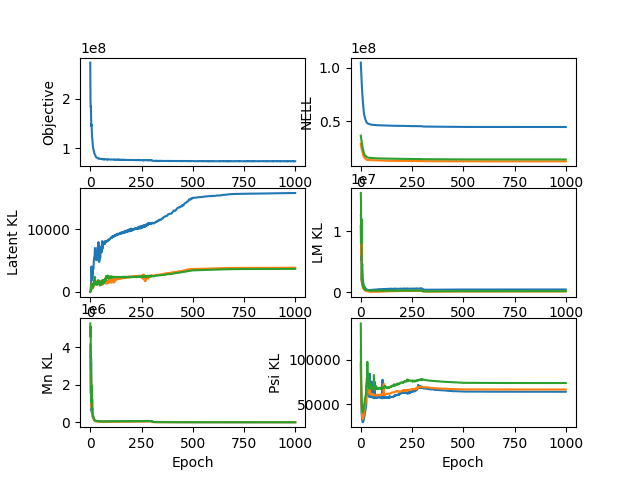

In [16]:
fitter.plot_log(log)

## View latents estimated with the sp models

In [17]:
props_conc = torch.cat([locs for locs in neuron_locs.values()], dim=0)
prior_lm_conc = priors.lm_prior(props_conc).detach().numpy()

In [18]:
sp_latents = dict()
for s_n, posteriors_n in posteriors.items():

    latents_n = posteriors_n.latent_post.mns.detach().numpy()
    _, latents_o = orthonormalize(prior_lm_conc, latents_n, unit_len_columns=False )
        
    sp_latents[s_n] = {'latents': latents_n, 'latents_o': latents_o}

<IPython.core.display.Javascript object>


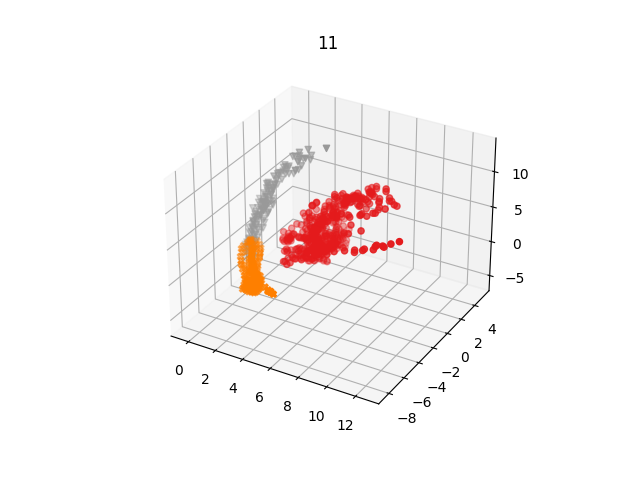

In [19]:
start_dim = 0

plt.figure()
ax = plt.axes(projection='3d')

for s_i, s_n in enumerate(sp_latents.keys()):
    #ax = plt.subplot(2,2, s_i+1, projection='3d')
    plot_latents = sp_latents[s_n]['latents_o']
    plot_labels = fit_labels_conc[s_n]
    
    for sp, sp_lbl in label_map.items():
        sp_clr = subperiod_clrs[sp]
        sp_inds = plot_labels == sp_lbl
        ax.scatter(plot_latents[sp_inds,start_dim+0], plot_latents[sp_inds,start_dim+1], 
                   plot_latents[sp_inds,start_dim+2], color=sp_clr, marker=subject_markers[s_n])
    plt.title(str(s_n))

## Visualize loading matrices across space for the sp models

In [20]:
vis_comp = 1

<IPython.core.display.Javascript object>


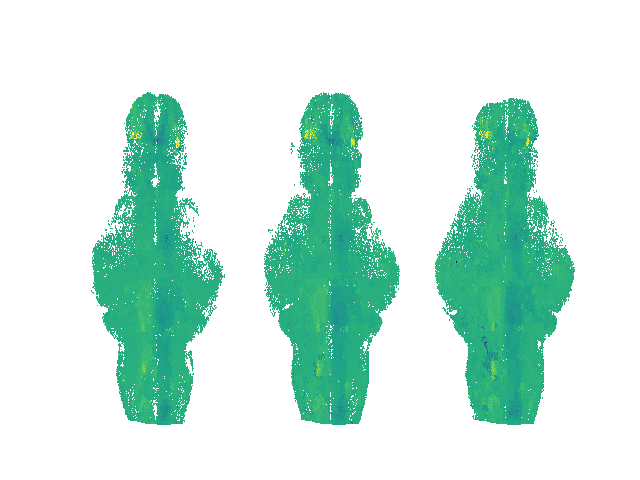

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

In [21]:
_, _, o_vis = svd(prior_lm_conc, full_matrices=False)

mode_imgs = dict()
for s_n in subjects:
    neuron_locs_n = neuron_locs[s_n]
    
    lm_n = posteriors[s_n].lm_post(neuron_locs_n).detach().numpy()
    lm_n = np.matmul(lm_n, o_vis.transpose())
    
    #lm_n = posteriors[s_n].mn_post(neuron_locs_n).detach().numpy()
    
    mode_imgs[s_n], _ = max_project_pts(dot_positions=neuron_locs_n.numpy()[:,[0,1]].astype('float'),
                                        dot_vls=lm_n[:,vis_comp], 
                                        box_position=np.asarray([[0, 0], [990, 610]]), 
                                        n_divisions=np.asarray([990, 610]), 
                                        dot_dim_width=np.asarray([5,5]))
    
plt.figure()
cmp_n_mats([mode_imgs[k] for k in mode_imgs.keys()])   